In [1]:
import numpy as np
import numpy.random as npr
from scipy.linalg import solve_discrete_are

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
hz = 60.0
_sat = 5.0
def f(s, a):
    th, x, thdot, xdot = s
    sdot = np.array([
                thdot, xdot,
                9.81*np.sin(th)/1.0+_sat*a[0]*np.cos(th)/1.0-0.2*thdot,
                _sat*a[0]-0.1*xdot])
    return s + sdot/hz

In [4]:
def wrap2Pi(x):
    th = np.fmod(x+np.pi, 2.0 * np.pi)
    if th < 0:
        th = th + 2.0 * np.pi
    return th - np.pi

Q = np.diag([10., .2, 0., 0.05, 0., 0., 0.])
Qf = np.diag([20., 0.2, 0., 0., 0., 0.,0.])
R = np.diag([0.01])

Rinv = np.linalg.inv(R)

def l(x): #loss in z space
    x[0] = wrap2Pi(x[0])
    return np.dot(x, np.dot(Q, x))

def ldx(x):
    x[0] = wrap2Pi(x[0])
    return 2.*np.dot(Q, x)

def m(x): #loss in z space
    x[0] = wrap2Pi(x[0])
    return np.dot(x, np.dot(Qf, x))

def mdx(x):
    x[0] = wrap2Pi(x[0])
    return 2.*np.dot(Qf, x)


In [5]:
state_dim = 4
action_dim = 1

num_x_obs = 7
num_u_obs = 2
num_obs = num_x_obs + num_u_obs

def z(s):
    th, x, thdot, xdot = s
    return np.array([th, x, thdot, xdot, np.sin(th), np.cos(th), 1.])

def v(s, a):
    th, x, thdot, xdot = s
    return np.array([a[0], np.cos(th) * a[0]])

def dvdu(s, a):
    return np.array([[1.0, np.cos(s[0])]]).T
def dvdz(s, a):
    th, x, thdot, xdot = s
    out = np.zeros((num_u_obs, num_x_obs))
    out[:,0] = np.array([0., -np.sin(th) * a[0]])
    return out 

In [6]:
npr.seed(0) ## set the seed for reproducibility 
num_trials = 60 ## number of resets
horizon    = 100 ## how long we simulate the system for
M = num_trials * horizon ## M sized data

_A = np.zeros((num_obs, num_obs))
_G = np.zeros((num_obs, num_obs))
cnt = 0
s_bnds = np.array([6.24, 1.0, 2.0, 2.0])
a_bnds = np.array([1.])
## loop to collect data
for k in range(num_trials):
#     x_t = npr.uniform(low=-s_bnds, high=s_bnds)
    x_t = npr.normal(s_bnds*0., s_bnds)
    for t in range(horizon):
        u_t = npr.normal(0.*a_bnds, a_bnds)
        x_tpo = f(x_t, u_t)
        u_tpo = u_t

        z1 = np.concatenate([z(x_t), v(x_t, u_t)])
        z2 = np.concatenate([z(x_tpo), v(x_tpo, u_t)])
        cnt += 1
        _A += np.outer(z2, z1)/cnt
        _G += np.outer(z1, z1)/cnt
        
        # reset for next loop
        x_t = x_tpo
        u_t = u_tpo

        
# _A /= M
# _G /= M

K = np.dot(_A, np.linalg.pinv(_G))
A = K[:num_x_obs,:num_x_obs]
B = K[:num_x_obs, num_x_obs:]

# A[np.abs(A)<1e-3] = 0
# B[np.abs(B)<1e-3] = 0

In [7]:
T = int(1.5*hz)
u = [np.zeros(1) for t in range(T)]
def update(x, u, A, B):
    zt = z(x.copy())
    zot = []
    for t in range(T):
        zt = z(zt[:state_dim])
        zot.append(zt.copy())
        zt = np.dot(A, zt) + np.dot(B, v(zt[:state_dim], u[t]))
    rho = np.zeros_like(zt)
    for t in reversed(range(T)):
        Bdz = np.dot(B, dvdz(zot[t][:state_dim], u[t]))
        rho = ldx(zot[t].copy()) + np.dot((A+Bdz).T, rho)
        Beff = np.dot(B, dvdu(zot[t], u[t]))
#         u[t] = np.clip(-Rinv.dot(Beff.T.dot(rho)), -1., 1.)
        du = Beff.T.dot(rho) + 2.0 * R.dot(u[t])
        u[t] = np.clip(u[t] - 0.1 * du, -1, 1)
    return u

In [10]:
xt = np.array([3.14, 0., 0., 0.])

trajectory = []

for t in range(int(40*hz)):
    u[:-1] = u[1:]
    u[-1] = np.zeros_like(u[-1])
    u = update(xt, u, A, B)

    u1 = u[0]
    xtpo = f(xt, u1)

    z1 = np.concatenate([z(xt), v(xt, u1)])
    z2 = np.concatenate([z(xtpo), v(xtpo, u1)])
    cnt +=1 
    _A += np.outer(z2, z1)/cnt
    _G += np.outer(z1, z1)/cnt
    
    K = np.dot(_A, np.linalg.pinv(_G))
    A = K[:num_x_obs,:num_x_obs]
    B = K[:num_x_obs, num_x_obs:]
    
    xt = xtpo
    
    trajectory.append(xt.copy())
    if t % 50 == 0:
        print(xt)

[ 3.14   0.    -0.083  0.083]
[ 3.687 -1.084  0.243 -2.484]
[ 3.53  -4.612 -0.403 -5.955]
[  3.075 -10.117  -1.177  -6.16 ]
[  2.163 -13.39    0.54   -1.666]
[  4.034 -14.145   2.269  -1.077]
[  2.43  -13.35   -4.608   3.01 ]
[ 1.728 -9.284  3.533  6.77 ]
[ 5.696 -4.774  2.39   4.687]
[ 6.422 -1.554  0.083  2.878]
[6.464 0.192 0.097 1.326]
[ 6.396  0.543 -0.124 -0.249]
[ 6.368  0.09  -0.055 -0.923]
[ 6.348 -0.888 -0.041 -1.445]
[ 6.3   -2.223  0.06  -1.544]
[ 6.29  -3.609 -0.117 -1.792]
[ 6.309 -4.947 -0.064 -1.67 ]
[ 6.229 -6.374 -0.064 -1.573]
[ 6.226 -7.371 -0.121 -1.008]
[ 6.128 -7.872 -0.088 -0.008]
[ 6.162 -7.284 -0.002  1.187]
[ 6.175 -5.938  0.035  2.034]
[ 6.198 -3.997 -0.028  2.548]
[ 6.209 -1.654  0.028  3.04 ]
[6.267 1.013 0.207 3.398]
[6.407 3.59  0.031 2.485]
[ 6.415  5.147 -0.093  1.152]
[ 6.384  5.698 -0.007  0.186]
[ 6.378  5.533 -0.051 -0.626]
[ 6.39   4.761 -0.079 -1.411]
[ 6.371  3.346 -0.049 -2.042]
[ 6.364  1.473 -0.029 -2.513]
[ 6.335 -0.774  0.045 -2.749]
[ 6.31

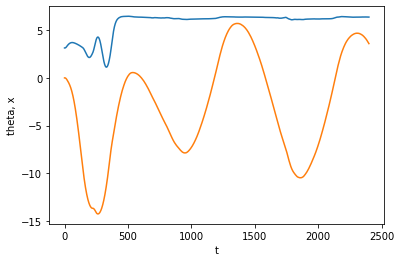

In [11]:
import matplotlib.pyplot as plt
trajectory = np.stack(trajectory)
plt.plot(trajectory[:,0])
plt.plot(trajectory[:,1])
plt.xlabel('t')
plt.ylabel('theta, x')
plt.show()